In [ ]:
!pip install pennylane
from IPython.display import clear_output
clear_output()

In [ ]:
import pennylane as qml

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:

n_epochs = 10     # number of epochs to run
n_layers = 1      # number of random layers
n_train = 50      # size of training dataset
n_test = 30       # size of test dataset



SAVE_PATH = 'qcnn/'   # where to save
PREPROCESS = True    # if false, skip quantum processing and load data from saved path

np.random.seed(135)
tf.random.set_seed(135)


In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]

# for the test data
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]


In [ ]:

train_images = train_images / 255
test_images = test_images / 255



In [ ]:
#Adding an extra dimension for the convolutional channels

train_images = np.array(train_images[..., tf.newaxis], requires_grad = False)

test_images = np.array(test_images[..., tf.newaxis], requires_grad = False)


In [ ]:
dev = qml.device('default.qubit', wires=4)

# now the random circuit

rand_params = np.random.uniform(high=2*np.pi, size = (n_layers,4))

@qml.qnode(dev)

def circuit(phi):
  # encoding of 4 classical input
  for j in range(4):
    qml.RY(np.pi *phi[j], wires = j)

  # random circuit

  RandomLayers(rand_params, wires = list(range(4)))


  # Measurement
  return [qml.expval(qml.PauliZ(j)) for j in range(4)]



In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save( "q_train_images.npy", q_train_images)
    np.save( "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load( "q_train_images.npy")
q_test_images = np.load( "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


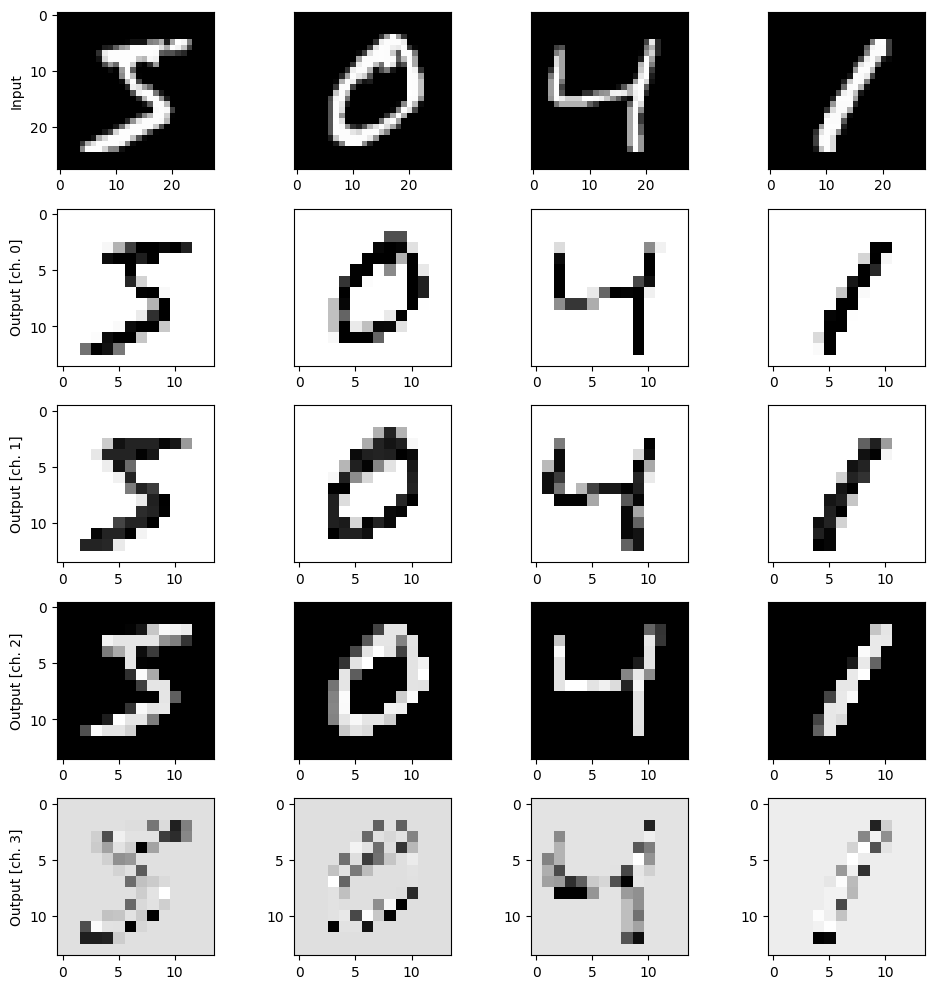

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/10
13/13 - 3s - 220ms/step - accuracy: 0.1200 - loss: 2.6738 - val_accuracy: 0.2333 - val_loss: 2.4661
Epoch 2/10
13/13 - 0s - 24ms/step - accuracy: 0.3000 - loss: 1.9567 - val_accuracy: 0.4000 - val_loss: 2.1844
Epoch 3/10
13/13 - 0s - 8ms/step - accuracy: 0.5600 - loss: 1.5685 - val_accuracy: 0.4333 - val_loss: 1.9553
Epoch 4/10
13/13 - 0s - 7ms/step - accuracy: 0.7600 - loss: 1.2345 - val_accuracy: 0.5333 - val_loss: 1.7857
Epoch 5/10
13/13 - 0s - 10ms/step - accuracy: 0.8800 - loss: 0.9975 - val_accuracy: 0.5333 - val_loss: 1.6770
Epoch 6/10
13/13 - 0s - 11ms/step - accuracy: 0.9200 - loss: 0.8127 - val_accuracy: 0.5333 - val_loss: 1.5763
Epoch 7/10
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 0.6710 - val_accuracy: 0.5333 - val_loss: 1.4938
Epoch 8/10
13/13 - 0s - 8ms/step - accuracy: 0.9400 - loss: 0.5613 - val_accuracy: 0.5333 - val_loss: 1.4324
Epoch 9/10
13/13 - 0s - 8ms/step - accuracy: 0.9600 - loss: 0.4755 - val_accuracy: 0.5333 - val_loss: 1.3816
Epoch 10/10
13

In [ ]:

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


Epoch 1/10
13/13 - 2s - 120ms/step - accuracy: 0.1200 - loss: 2.3249 - val_accuracy: 0.1667 - val_loss: 2.1959
Epoch 2/10
13/13 - 0s - 25ms/step - accuracy: 0.4200 - loss: 1.9235 - val_accuracy: 0.3333 - val_loss: 2.0463
Epoch 3/10
13/13 - 0s - 8ms/step - accuracy: 0.6000 - loss: 1.6474 - val_accuracy: 0.4333 - val_loss: 1.9126
Epoch 4/10
13/13 - 0s - 11ms/step - accuracy: 0.7400 - loss: 1.4179 - val_accuracy: 0.4667 - val_loss: 1.7896
Epoch 5/10
13/13 - 0s - 8ms/step - accuracy: 0.8400 - loss: 1.2247 - val_accuracy: 0.5667 - val_loss: 1.6824
Epoch 6/10
13/13 - 0s - 10ms/step - accuracy: 0.8600 - loss: 1.0636 - val_accuracy: 0.5667 - val_loss: 1.5924
Epoch 7/10
13/13 - 0s - 11ms/step - accuracy: 0.8600 - loss: 0.9300 - val_accuracy: 0.6000 - val_loss: 1.5179
Epoch 8/10
13/13 - 0s - 8ms/step - accuracy: 0.8800 - loss: 0.8189 - val_accuracy: 0.6000 - val_loss: 1.4558
Epoch 9/10
13/13 - 0s - 7ms/step - accuracy: 0.9000 - loss: 0.7256 - val_accuracy: 0.6000 - val_loss: 1.4035
Epoch 10/10
1

In [ ]:
pip install seaborn


In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


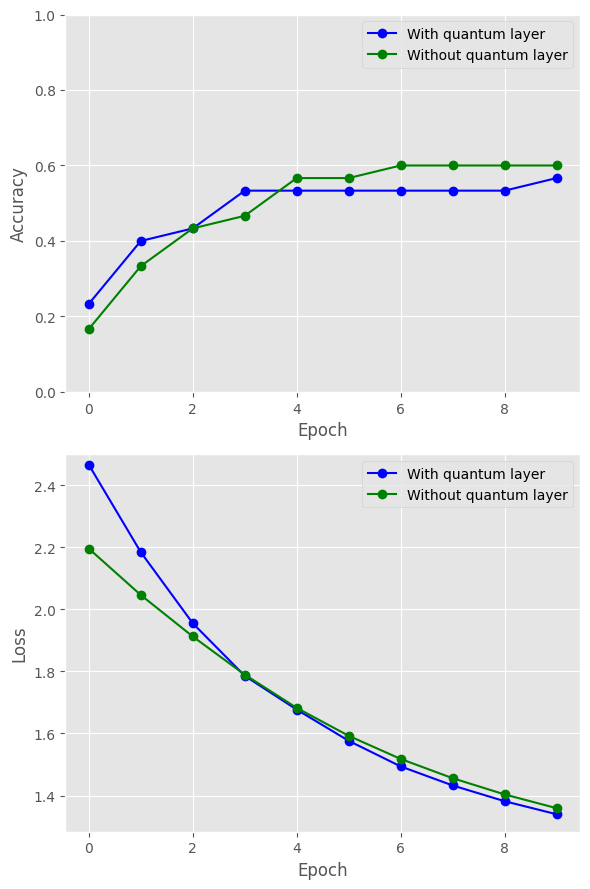

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')  # or 'classic', 'bmh', etc.

#plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
